In [ ]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


## Dataset load and plot

In [ ]:
import numpy as np
import pandas as pd

Train_set = pd.read_csv('/content/drive/MyDrive/Kaggle/train.csv')
Test_set = pd.read_csv('/content/drive/MyDrive/Kaggle/test.csv')

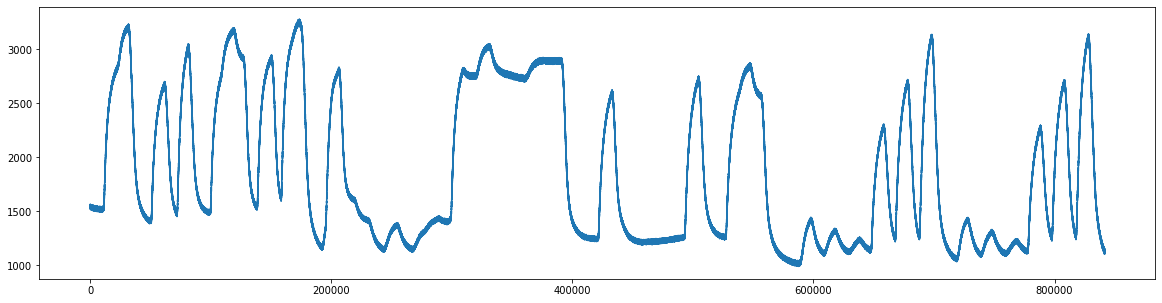

In [ ]:
#draw_graph and draw_graph_2 function help us draw label / sensor data / predicted label

import matplotlib.pyplot as plt

def draw_graph(seq, alpha = 1):
    n = len(seq)
    plt.figure(figsize = (20,5))
    plt.plot(seq[:int(alpha*n)]);

def draw_graph_2(seq1, seq2, alpha = 1, equal_h = True):
    n1 = len(seq1)
    n2 = len(seq2)
    if n1 != n2:
        print('length different!')
        return None
    
    else: 
        n = n1

        if equal_h == True:

            max_1 = np.max(seq1)
            max_2 = np.max(seq2)

            ratio = max_2 / max_1

            plt.figure(figsize = (20,5))
            plt.plot(seq1[:int(alpha*n)] * ratio)
            plt.plot(seq2[:int(alpha*n)]);
        
        else:

            plt.figure(figsize = (20,5))
            plt.plot(seq1[:int(alpha*n)])
            plt.plot(seq2[:int(alpha*n)]);

draw_graph(Test_set['s1'])

## New dataset : using average

In [ ]:
#make_aver function has input of sequence and output of averaged (down_sampled) sequence
#average_length is given 50 as a default

def make_aver(seq, average_length = 50):

    seq_raw = np.array(seq)
    n = len(seq_raw)

    seq_aver = np.zeros(int(n/average_length)+1, dtype = np.float64)

    for i in range(int(n/average_length)):
        seq_aver[i] = np.mean(seq_raw[i * average_length : (i+1) * average_length])

    seq_aver[i+1] = np.mean(seq_raw[(i+1) * average_length:])

    return seq_aver

#truncate function can push or pull the given sequence 

def truncate(seq, start = 0, end = 0):

    seq_raw = np.array(seq)

    return seq_raw[start:len(seq_raw)-end]

#make_train_set make a train_set for training for time-series
#It retunrns a full_data set with nearby sequence data with given window_size

def make_train_set(seq_list, target, window_size = 50, train = True):

    num = len(seq_list)
    l = len(seq_list[0])
    s = int(window_size / 2)
    x_train = seq_list[0][0:l-window_size].reshape(-1,1)

    for i in range(1,window_size+1):
        x_train = np.hstack((x_train, seq_list[0][i:l-window_size+i].reshape(-1,1)))

    for j in range(1,num):
        for i in range(0,window_size+1):
            x_train = np.hstack((x_train, seq_list[j][i:l-window_size+i].reshape(-1,1)))

    if train:
        return x_train, target[s:l-s]
    else:
        return x_train

In [ ]:
from scipy.stats import pearsonr

sensor_corr_dict = {}

column_list = list(Train_set.columns[3:])
label_aver = make_aver(Train_set['label'])

for sensor in column_list:

    sen_seq = make_aver(Train_set[sensor])
    max = pearsonr(sen_seq,label_aver)[0]
    flag = 0

    for start in range(1,400):
        r = pearsonr(sen_seq[start:], label_aver[:-start])[0]
        if r > max:
            flag = start
            max = r

    sensor_corr_dict[sensor] = [flag, max]

    print('sensor_name: ', sensor, 'push: ', flag, 'cor_val: ', max)

sensor_name:  s1 push:  93 cor_val:  0.8855624533690216
sensor_name:  s2 push:  89 cor_val:  0.09306593717036885
sensor_name:  s3 push:  51 cor_val:  0.3040919447934366
sensor_name:  s4 push:  52 cor_val:  0.3385211003700751
sensor_name:  s5 push:  43 cor_val:  0.6274085858158943
sensor_name:  s6 push:  41 cor_val:  0.7090569637870527
sensor_name:  s7 push:  44 cor_val:  0.31730348127598473
sensor_name:  s8 push:  44 cor_val:  0.3133003553473909
sensor_name:  s9 push:  99 cor_val:  0.5599798190461016
sensor_name:  s10 push:  102 cor_val:  0.6317650696200782
sensor_name:  s11 push:  55 cor_val:  0.2870427976026955
sensor_name:  s12 push:  52 cor_val:  0.35995604279068105
sensor_name:  s13 push:  46 cor_val:  0.6428148192527214
sensor_name:  s14 push:  45 cor_val:  0.6496345786038376
sensor_name:  s15 push:  44 cor_val:  0.2072262214578247
sensor_name:  s16 push:  44 cor_val:  0.40865558712832917


In [ ]:
def make_sensor_push_data(dataset):

    sensor_push_data = []

    for sensor in column_list:
        push = sensor_corr_dict[sensor][0]
        sensor_push_data.append(truncate(make_aver(dataset[sensor]), start = push, end = 103 - push))

    return sensor_push_data

## Linear regression based contaminated (linear combination) sensor

In [ ]:
#Make a linear combination of given sensors

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

def make_linear_sensor(start = 100):

    train_sensor_push_data = make_sensor_push_data(Train_set)

    scaler = StandardScaler()
    train_sensor_mod_list = scaler.fit_transform(np.array(train_sensor_push_data).T)

    linearizer = LinearRegression()
    linearizer.fit(train_sensor_mod_list, truncate(label_aver, start = 0, end = 103).reshape(-1,1))
    linear_sensor = linearizer.predict(train_sensor_mod_list).flatten()

    linear_new_sensor = truncate(linear_sensor, start = start)

    return scaler, linearizer, linear_new_sensor

In [ ]:
#new_sensor : linear combination of 16 sensors

scaler, linearizer, new_sensor = make_linear_sensor()

In [ ]:
new_label = truncate(make_aver(Train_set['label']), start = 100, end = 103)

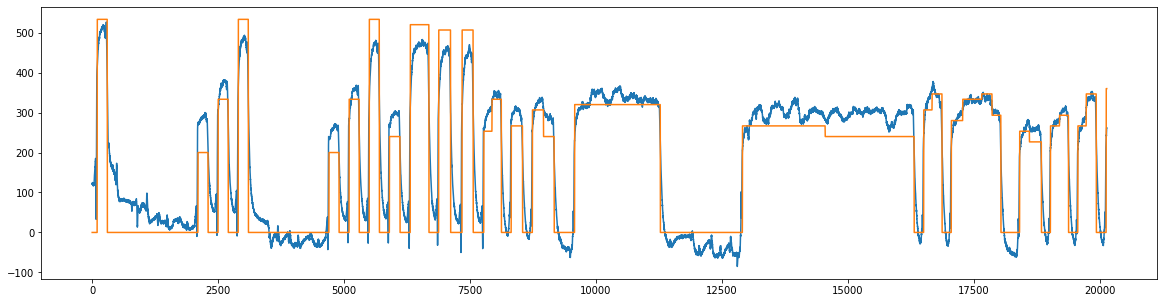

In [ ]:
draw_graph_2(, new_label, alpha = 0.3)

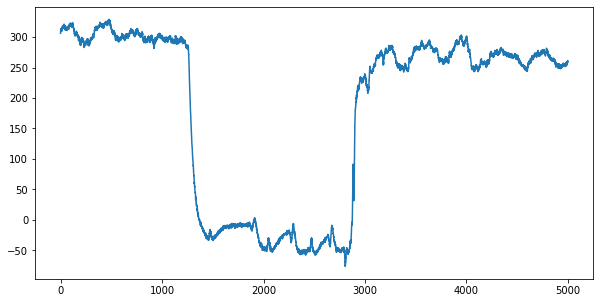

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(new_sensor[10000:15000]);

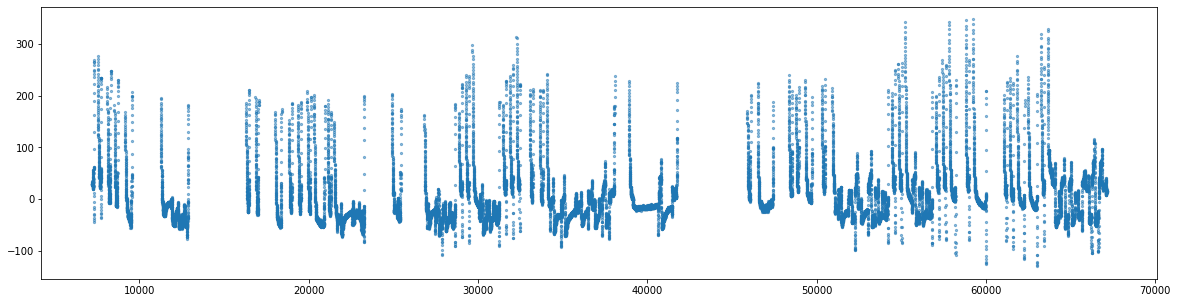

In [ ]:
#make a new dataframe in order to find a trend for zero_label points

new_df_zero = new_df[new_df['label'] == 0]
index_trend = np.array(new_df_zero.index)[5000:]
sensor_trend = np.array(new_df_zero.sensor)[5000:]

plt.figure(figsize = (20,5))
plt.scatter(index_trend, sensor_trend, s = 5, alpha = 0.5);

In [ ]:
#Use a linear fitting for estimating the trend

trend_regressor = LinearRegression()
trend_regressor.fit(index_trend.reshape(-1,1), sensor_trend.reshape(-1,1))
trend_beta = trend_regressor.coef_[0][0]

In [ ]:
def trend_modifier(seq, train = True):
    seq_mod = seq.copy()
    if train:
        seq_mod[5000:] = seq[5000:] - np.array(range(len(seq) - 5000)) * trend_beta
        return seq_mod 
    else:
        seq_mod = seq - np.array(range(len(seq))) * trend_beta - np.ones(len(seq)) * trend_beta * (len(new_sensor) + 203)
        return seq_mod

In [ ]:
new_sensor_mod = trend_modifier(new_sensor, train = True)

## First prediction (without trend removing)

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

def catboost_pred(sensor,label):
    x_train, y_train = make_train_set([sensor], label)
    model = CatBoostRegressor(iterations = 10000)
    model.fit(x_train, y_train, verbose = False)
    pred_label = model.predict(x_train)
    print(mean_absolute_error(y_train, pred_label))
    return model, pred_label

catboost_model, pred_label_1 = catboost_pred(new_sensor, new_label)

6.743469681286184


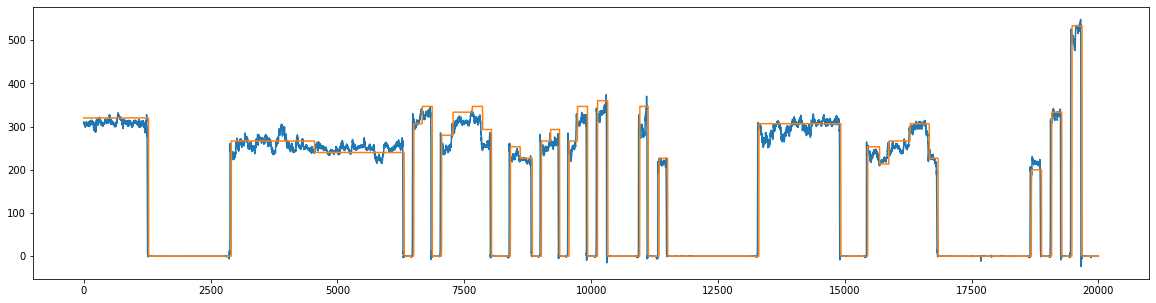

In [ ]:
draw_graph_2(pred_label_1[10000:30000], new_label[10000:30000], equal_h = False)

## Test_set prediction

In [ ]:
def make_test_new_sensor(start = 0):

    #push each sensor in a correct place
    test_sensor_push_data = make_sensor_push_data(Test_set)

    #scaling
    test_sensor_mod_list = scaler.transform(np.array(test_sensor_push_data).T)

    #make linear combination
    test_new_sensor = linearizer.predict(test_sensor_mod_list).flatten()

    #truncate
    test_new_sensor = truncate(test_new_sensor, start = start, end = 0)

    return test_new_sensor

In [ ]:
test_new_sensor = make_test_new_sensor()

In [ ]:
x_test = make_train_set(seq_list = [test_new_sensor], target = None, train = False)

In [ ]:
#simple_pred_filter

def simple_pred_filter(seq_raw, th = 150):
    seq = seq_raw.copy()
    for i in range(len(seq)):
        if seq[i] < th:
            seq[i] = 0
        if seq[i] > 533.33:
            seq[i] = 533.33
    return seq

test_pred_1 = catboost_model.predict(x_test)
test_pred_2 = simple_pred_filter(test_pred_1, th = 150)

## Trend remover

In [ ]:
new_df = pd.DataFrame({'sensor' : np.hstack((new_sensor,np.ones(103),test_new_sensor)),
                       'label' : np.hstack((new_label,np.ones(103),np.zeros(25),test_pred_2,np.zeros(25)))})

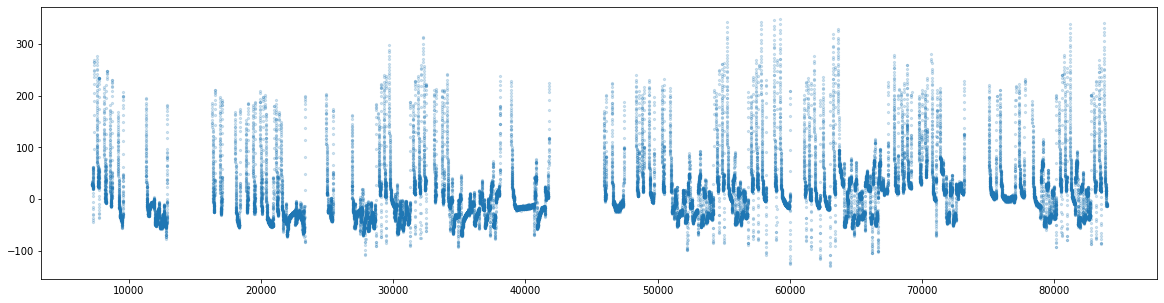

In [ ]:
new_df_zero = new_df[new_df['label'] == 0]
index_trend = np.array(new_df_zero.index)[5000:]
sensor_trend = np.array(new_df_zero.sensor)[5000:]

plt.figure(figsize = (20,5))
plt.scatter(index_trend, sensor_trend, s = 5, alpha = 0.2);

In [ ]:
trend_regressor = LinearRegression()
trend_regressor.fit(index_trend.reshape(-1,1), sensor_trend.reshape(-1,1))
trend_beta = trend_regressor.coef_[0][0]

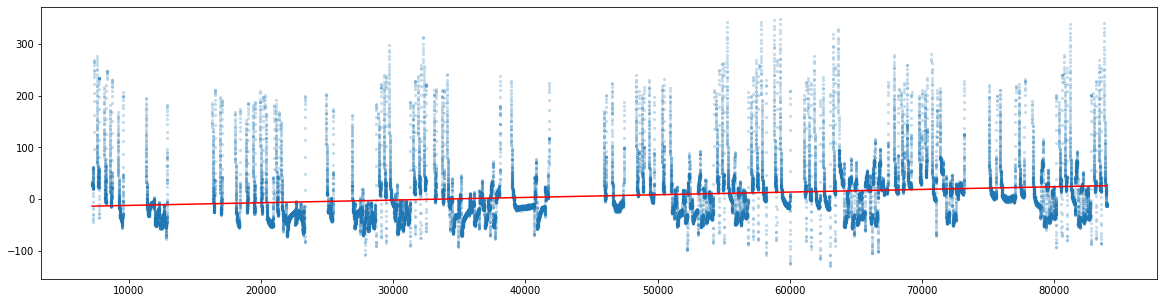

In [ ]:
plt.figure(figsize = (20,5))
X_plot = np.linspace(np.min(index_trend), np.max(index_trend), 100000).reshape(-1,1)
y_plot = trend_regressor.predict(X_plot)
plt.plot(X_plot,y_plot, c = 'r')
plt.scatter(index_trend, sensor_trend, s = 5, alpha = 0.2);

In [ ]:
def trend_modifier(seq, beta = trend_beta, train = True):
    seq_mod = seq.copy()
    if train:
        seq_mod[5000:] = seq[5000:] - np.array(range(len(seq) - 5000)) * beta
        return seq_mod 
    else:
        seq_mod = seq - np.array(range(len(seq))) * beta - np.ones(len(seq)) * beta * (len(new_sensor) + 128)
        return seq_mod

In [ ]:
new_sensor_mod = trend_modifier(new_sensor, beta = trend_beta, train = True)
test_new_sensor_mod = trend_modifier(test_new_sensor, beta = trend_beta, train = False)

## Second prediction (using trend remover function)

In [ ]:
#Second prediction
trend_catboost_model, pred_label_2 = catboost_pred(new_sensor_mod, new_label)

5.551975088151526


In [ ]:
x_test_2 = make_train_set(seq_list = [test_new_sensor_mod], target = None, train = False)
test_pred_3 = trend_catboost_model.predict(x_test_2)
test_pred_4 = simple_pred_filter(test_pred_3, th = 150)

## Test set prediction modify

In [ ]:
jump_list = []
mod_jump_list = []

for i in range(len(test_pred_4)-1):
    if np.abs(test_pred_4[i+1] - test_pred_4[i]) > 100:
        jump_list.append(i)

jump_list.append(100000)

for i in range(len(jump_list)-1):
    if jump_list[i+1] - jump_list[i] > 10:
        mod_jump_list.append(jump_list[i])

len(mod_jump_list)

34

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(test_pred_4)
plt.scatter(mod_jump_list, np.zeros_like(mod_jump_list), alpha = 0.5, c = 'r');

In [ ]:
def find_double(start,end,seq_raw):

    seq = seq_raw[start:end]

    def error_func(b):
        value_1 = np.median(seq[:b])
        value_2 = np.median(seq[b:])
        diff = np.sum(np.abs(value_1 - seq[:b])) + np.sum(np.abs(value_2 - seq[b:]))
        return diff

    min_error = error_func(1)
    flag = 0
    
    for b in range(1,len(seq)-1):
        error_b = error_func(b)
        if error_b < min_error:
            min_error = error_b
            flag = b
    
    return flag + start


def find_triple(start,end,seq_raw):
    
    seq = seq_raw[start:end]

    def error_func(b1,b2):
        value_1 = np.median(seq[:b1])
        value_2 = np.median(seq[b1:b2])
        value_3 = np.median(seq[b2:])
        diff = np.sum(np.abs(value_1 - seq[:b1])) + np.sum(np.abs(value_2 - seq[b1:b2])) + np.sum(np.abs(value_3 - seq[b2:]))
        return diff

    min_error = error_func(1,2)
    flag = [0,1]
    
    for b1 in range(1,len(seq)-2):
        for b2 in range(b1+1, len(seq)-1):
            error_b = error_func(b1,b2)
            if error_b < min_error:
                min_error = error_b
                flag = [b1,b2]
    
    return [flag[0]+start, flag[1]+start]

In [ ]:
def find_closest(value):
    value_list = Train_set['label'].unique()
    min_val = 1000
    flag = 0
    for i in value_list:
        if np.abs(i - value) < min_val:
            flag = i
            min_val = np.abs(i - value)
    return flag       


def make_noise(alpha = 1.0, beta = 1.0, 
               simple = [0,0,0,0,0,0,0], 
               double = [[0,0],[0,0]], 
               triple = [[0,0,0],[0,0,0]]):
    
    test_pred_5 = test_pred_4.copy()

    double_list = [0,10]
    triple_list = [6,20]
    simple_list = [2,4,8,12,14,16,18]
    pattern_list_1 = [22,24,26]
    pattern_list_2 = [28,30,32]
    pattern_value = [200.0,333.33,533.33]

    k = 0

    for index in simple_list:
        start = mod_jump_list[index]
        end = mod_jump_list[index+1]
        median_value = find_closest(np.median(test_pred_4[start+5:end-5]) * alpha) + simple[k]
        for value in range(start,end):
            test_pred_5[value] = median_value 
        k+=1

    k = 0

    for index in double_list:
        start = mod_jump_list[index]
        end = mod_jump_list[index+1]
        mid = find_double(start,end,test_pred_4)
        median_value_1 = find_closest(np.median(test_pred_4[start+5:mid-5])*beta) + double[k][0]
        median_value_2 = find_closest(np.median(test_pred_4[mid+5:end-5])*beta) + double[k][1]
        for value in range(start,mid):
            test_pred_5[value] =  median_value_1
        for value in range(mid,end):
            test_pred_5[value] =  median_value_2
        k+=1

    k = 0

    for index in triple_list:
        start = mod_jump_list[index]
        end = mod_jump_list[index+1]
        mid1,mid2 = find_triple(start,end,test_pred_4)
        if k == 1:
            mid1 += 10
        median_value_1 = find_closest(np.median(test_pred_4[start+5:mid1-5])*beta) + triple[k][0]
        median_value_2 = find_closest(np.median(test_pred_4[mid1+5:mid2-5])*beta) + triple[k][1]
        median_value_3 = find_closest(np.median(test_pred_4[mid2+5:end-5])*beta) + triple[k][2]
        for value in range(start,mid1):
            test_pred_5[value] =  median_value_1
        for value in range(mid1,mid2):
            test_pred_5[value] =  median_value_2
        for value in range(mid2,end):
            test_pred_5[value] =  median_value_3
        
        k+=1

    k = 0

    for index in pattern_list_1:
        start = mod_jump_list[index]
        end = mod_jump_list[index+1]
        for value in range(start,end):
            test_pred_5[value] = pattern_value[k]
        k+=1

    k = 0

    for index in pattern_list_2:
        start = mod_jump_list[index]
        end = mod_jump_list[index+1]
        for value in range(start,end):
            test_pred_5[value] = pattern_value[k]
        k+=1

    return test_pred_5

In [ ]:
Train_set['label'].unique()

array([  0.  , 533.33, 200.  , 333.33, 240.  , 520.  , 506.67, 253.33,
       266.67, 306.67, 320.  , 346.67, 280.  , 293.33, 226.67, 360.  ,
       213.33, 386.67, 466.67, 400.  , 453.33])

In [ ]:
simple = [0, 13.33 * 2, -13.33, -13.33*2, 0, 0, 13.33]
double = [[-13.33,13.33],[-13.33,-13.33]]
triple = [[0,-13.33,-13.33],[13.33,0,-13.33*2]]
test_pred_5 = make_noise(simple = simple, double = double, triple = triple)

In [ ]:
gamma = 150
final_prediction = np.zeros_like(np.array(Test_set['s1']))

for i in range(len(test_pred_5)):
    final_prediction[1250-gamma+i*50 : 1250-gamma+(i+1)*50] = test_pred_5[i]

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Kaggle/sample_submission.csv')

In [ ]:
my_submission = sample_submission.copy()
my_submission['label'] = final_prediction
my_submission.to_csv('/content/drive/MyDrive/Kaggle/gas_sensor_sehun_final_3.csv', index=False)